In [176]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from src.data_processing import engeneer_features_xgboost
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind

In [130]:
# Load the data
data = pd.read_csv("../data/merged_data_ercot_2023.csv")
data["Datetime"] = pd.to_datetime(data["Datetime"])
data.set_index('Datetime', inplace=True)

continous_features = ["Energy","Temperature"]

respondent = "ERCO"

In [131]:
data = data.rename(columns = {"Energy_MW": "Energy"})

In [132]:
#Descriptive statistics
print("Descriptive Statistics:")
print("Dataset Shape: ", data.shape)
print("\nDataset Columns: ", data.columns)
print("\nDataset Info: ")
print(data.info())
print("\nDataset Head: ")
print(data.head())
print("\nSummary Statistics for numerical features: ")
print(data[continous_features].describe())
print("\nChecking for missing values: ")
print(data.isnull().sum())

Descriptive Statistics:
Dataset Shape:  (4394, 3)

Dataset Columns:  Index(['Energy', 'Temperature', 'IsHoliday'], dtype='object')

Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4394 entries, 2023-07-01 00:00:00 to 2023-12-31 00:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Energy       4394 non-null   int64  
 1   Temperature  4394 non-null   float64
 2   IsHoliday    4394 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 137.3 KB
None

Dataset Head: 
                     Energy  Temperature  IsHoliday
Datetime                                           
2023-07-01 00:00:00   76384         28.3          0
2023-07-01 01:00:00   73862         26.8          0
2023-07-01 02:00:00   70570         26.5          0
2023-07-01 03:00:00   67978         26.2          0
2023-07-01 04:00:00   64727         26.0          0

Summary Statistics for numerical features: 
             Energy

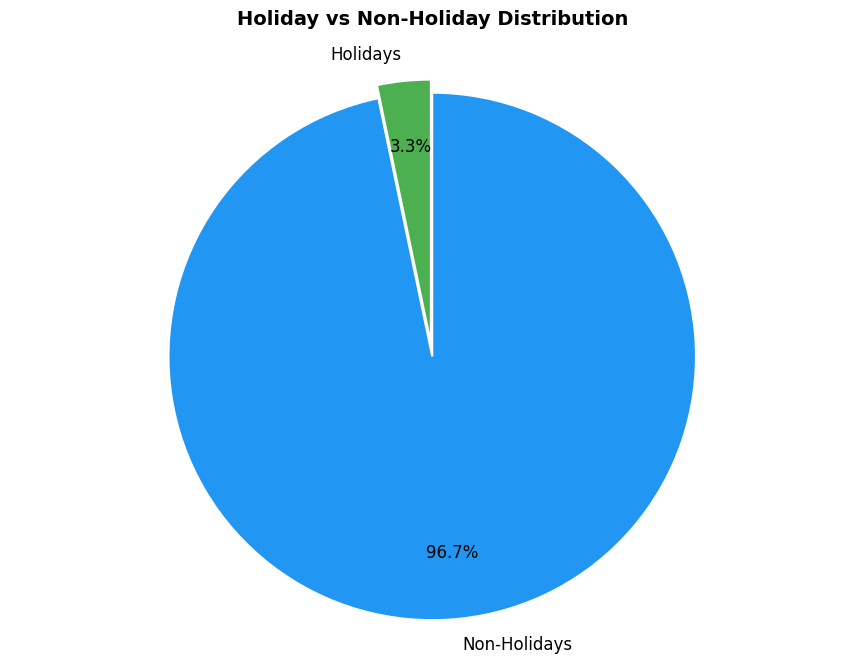

In [ ]:
# Ratio of holidays to non-holidays
holiday_count = data['IsHoliday'].sum()  
non_holiday_count = len(data['IsHoliday']) - holiday_count 

count = [holiday_count, non_holiday_count]
labels = ['Holidays', 'Non-Holidays']


plt.figure(figsize=(9, 7)) 
plt.pie(count, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=['#4CAF50', '#2196F3'], 
        explode=(0.05, 0), 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
        textprops={'fontsize': 12, 'color': 'black'},
        pctdistance=0.75,  
        labeldistance=1.1)  

plt.title('Holiday vs Non-Holiday Distribution', 
          fontsize=14, 
          fontweight='bold', 
          pad=20)

plt.axis('equal')
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_facecolor('white')
plt.tight_layout(pad=2.0)
plt.show()

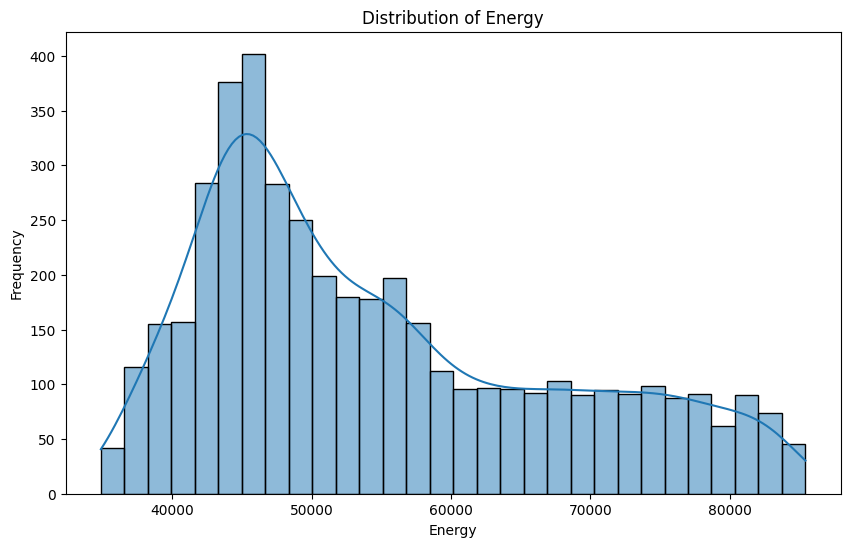

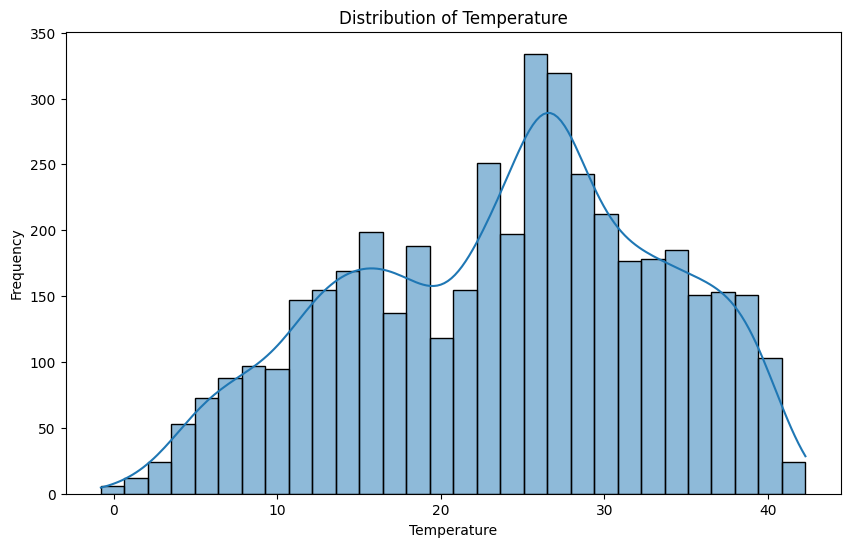

In [ ]:
# Histograms for continuous features
for col in data[continous_features]:
    plt.figure(figsize=(10, 6))
    plt.title(f"Distribution of {col}")
    sns.histplot(data[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

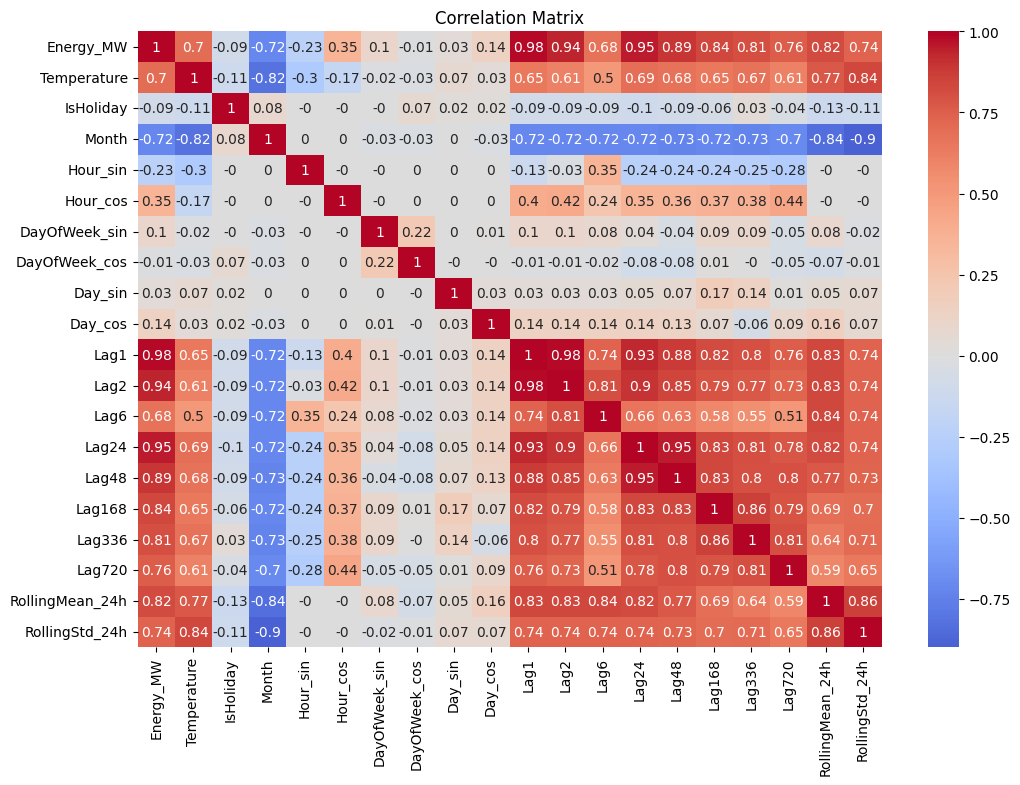

In [ ]:
#Correlation matrix 
data_corelations = engeneer_features_xgboost(data.rename(columns = {"Energy": "Energy_MW"})) #added features used for xgboost
correlation_matrix = round(data_corelations.corr('spearman'),2)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

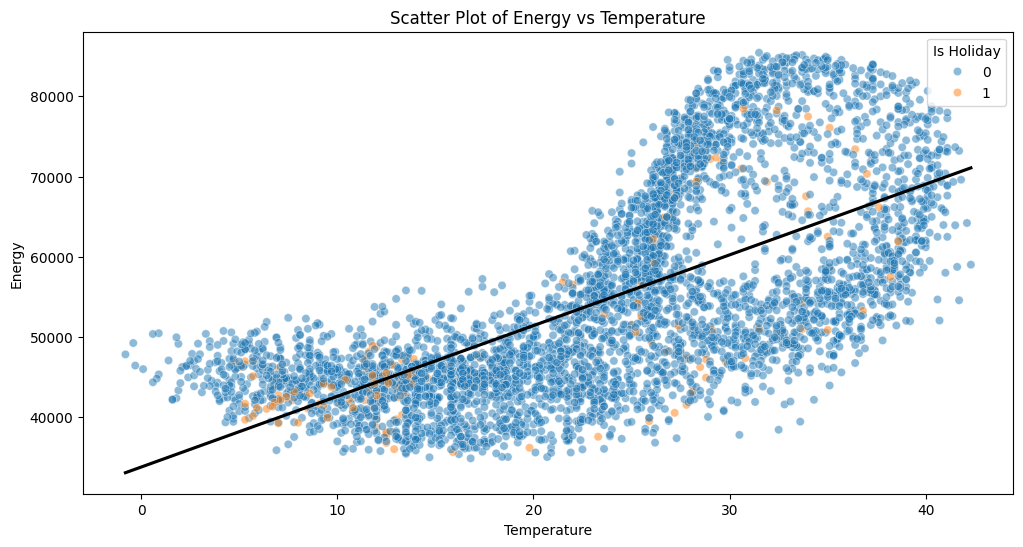

In [ ]:
#Scatter plot with regression line
plt.figure(figsize=(12,6))
sns.scatterplot(data=data, x="Temperature", y="Energy", hue="IsHoliday", alpha=0.5)
sns.regplot(data=data, x="Temperature", y="Energy", ci=None, scatter=False, color='black')
plt.title("Scatter Plot of Energy vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Energy")
plt.legend(title="Is Holiday", loc='upper right')
plt.show()

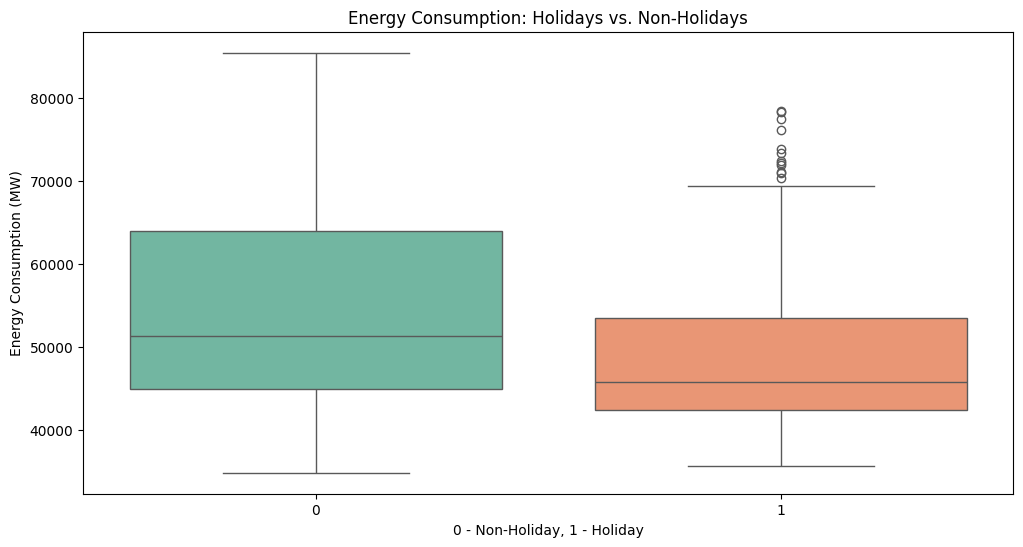

In [ ]:
# Boxplots for Energy consumption by Holiday status
plt.figure(figsize=(12, 6))
sns.boxplot(x='IsHoliday', y='Energy', data=data, palette='Set2', hue='IsHoliday',legend=False)
plt.title('Energy Consumption: Holidays vs. Non-Holidays')
plt.ylabel("Energy Consumption (MW)")
plt.xlabel("0 - Non-Holiday, 1 - Holiday")
plt.show()

In [ ]:
# Testing if the mean energy consumption is statisticaly different on holidays vs non-holidays
non_holiday_energy = data[data['IsHoliday'] == 0]['Energy']
holiday_energy = data[data['IsHoliday'] == 1]['Energy']

t_stat, p_value = ttest_ind(non_holiday_energy, holiday_energy, equal_var=False)

print("T-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in energy consumption between holidays and non-holidays is statistically significant (p < 0.05).")
else:
    print("The difference in energy consumption between holidays and non-holidays is not statistically significant (p >= 0.05).")

T-Test Results:
T-statistic: 6.0982
P-value: 0.0000
The difference in energy consumption between holidays and non-holidays is statistically significant (p < 0.05).


In [ ]:
# Feature engineering
data['month'] = [x for x in data.index.month_name()]
data['month_number'] = [x for x in data.index.month]
data['day'] = [x for x in data.index.day]
data['hour'] = [x for x in data.index.hour]
data['weekday'] = [x for x in data.index.weekday]

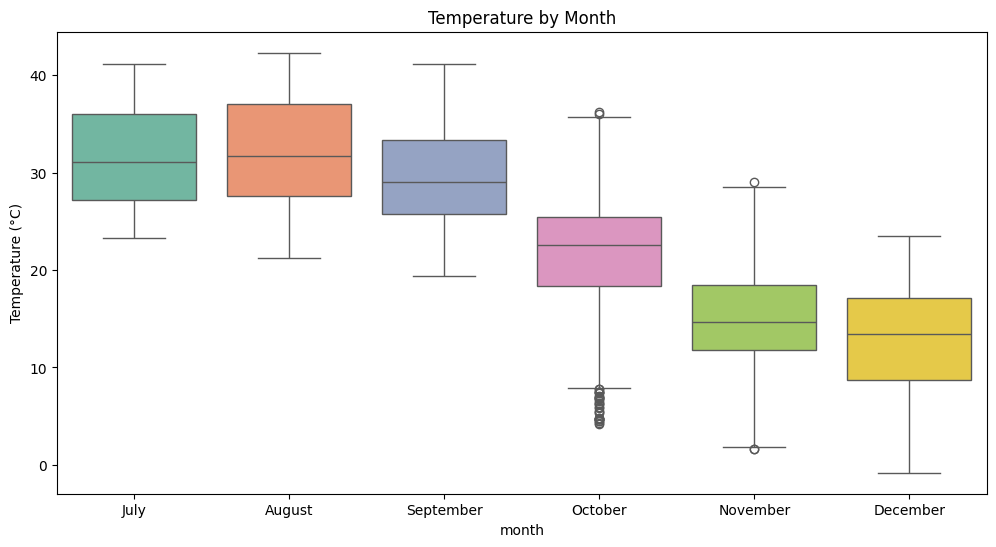

In [ ]:
# Boxplots for Energy by Month
plt.figure(figsize=(12, 6))
sns.boxplot(y='Temperature',x='month', data=data,palette='Set2', hue='month',legend=False)
plt.title('Temperature by Month')
plt.ylabel("Temperature (°C)")
plt.show()

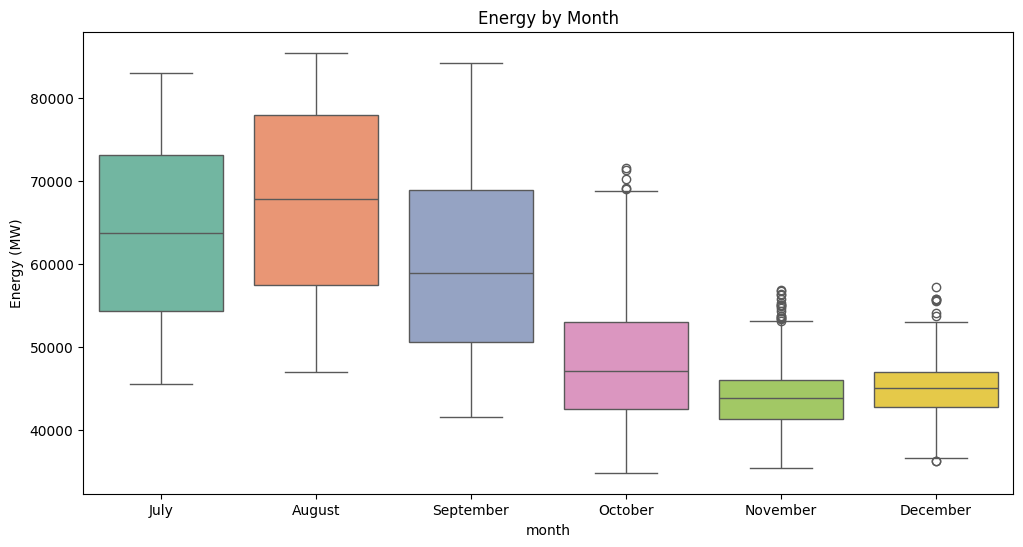

In [ ]:
# Boxplots for Energy by Month
plt.figure(figsize=(12, 6))
sns.boxplot(y='Energy',x='month', data=data,palette='Set2', hue='month',legend=False)
plt.title('Energy by Month')
plt.ylabel("Energy (MW)")
plt.show()

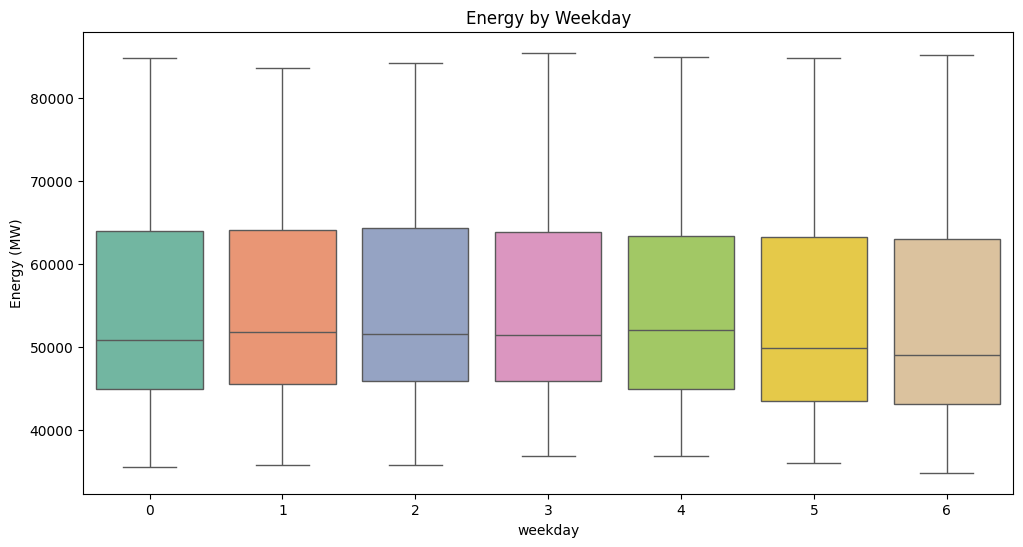

In [ ]:
# Boxplots for Energy by Weekday
plt.figure(figsize=(12, 6))
sns.boxplot(y='Energy',x='weekday', data=data,palette='Set2', hue='weekday',legend=False)
plt.title('Energy by Weekday')
plt.ylabel("Energy (MW)")
plt.show()

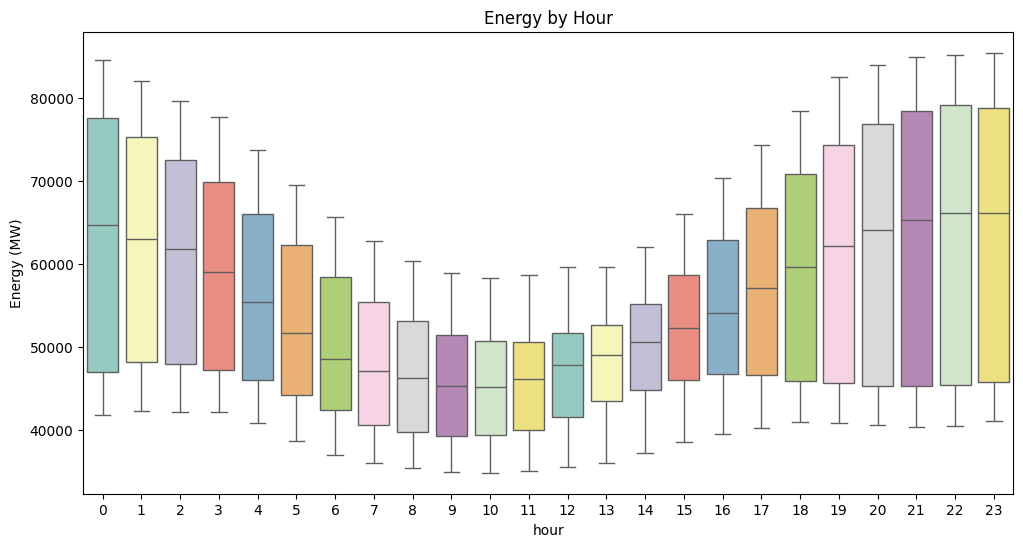

In [ ]:
# Boxplots for Energy by Hour
plt.figure(figsize=(12, 6))
sns.boxplot(y='Energy',x='hour', data=data,palette='Set3', hue='hour',legend=False)
plt.title('Energy by Hour')
plt.ylabel("Energy (MW)")
plt.show()

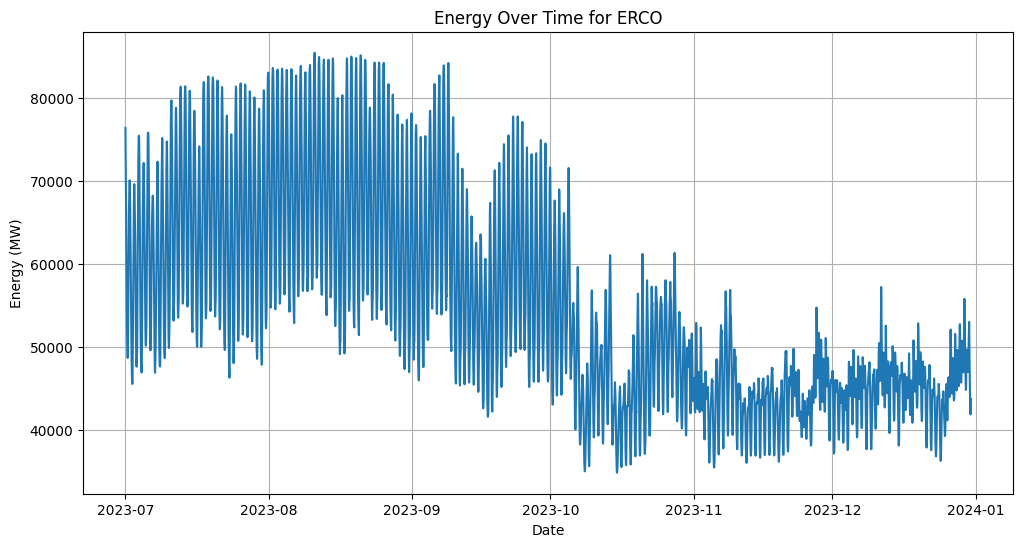

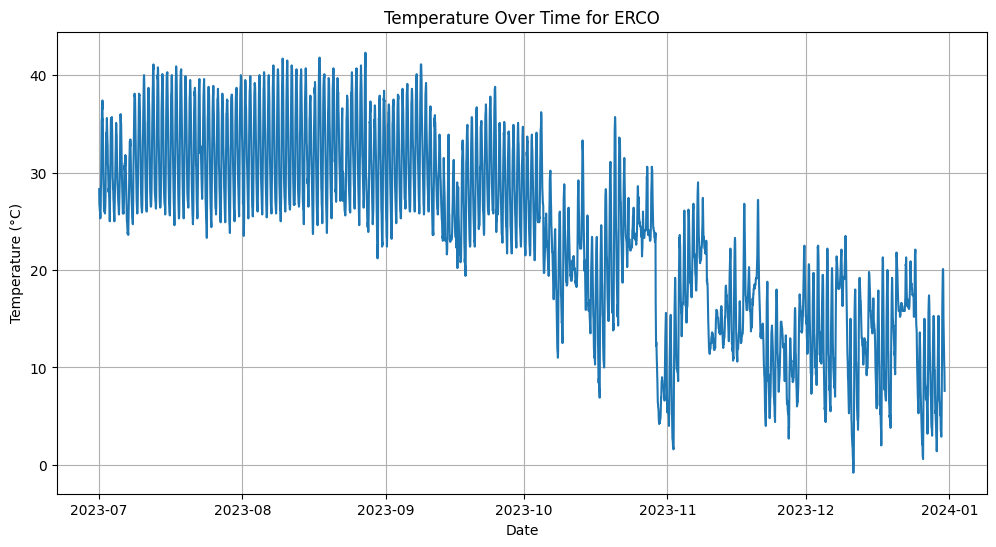

In [142]:
# Plotting the distribution of continuous features
for col in data[continous_features]:

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[col])
    plt.title(f"{col} Over Time for {respondent}")
    plt.xlabel("Date")
    if col == "Temperature":
        plt.ylabel("Temperature (°C)")
    elif col == "Energy":
        plt.ylabel("Energy (MW)")
    plt.grid()
    plt.show()

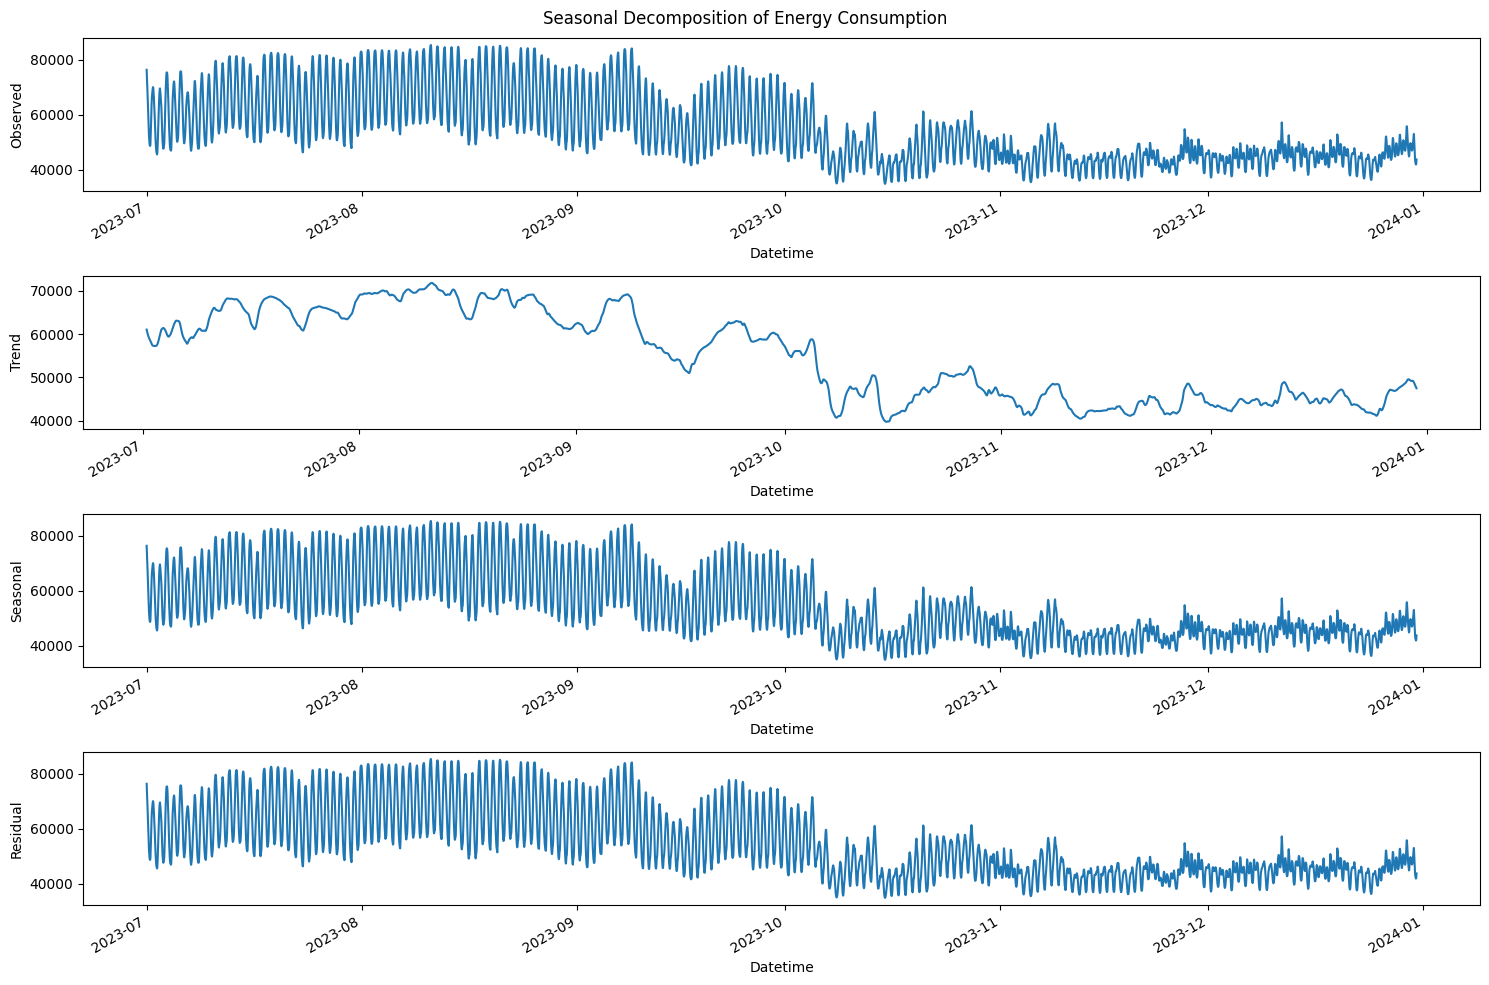

In [ ]:
# Seasonal decomposition of the energy consumption data
result_add = seasonal_decompose(data['Energy'], model='additive', period=24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Seasonal Decomposition of Energy Consumption')

result_add.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result_add.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result_add.observed.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result_add.observed.plot(ax=ax4)
ax4.set_ylabel('Residual')


plt.tight_layout()
plt.show()


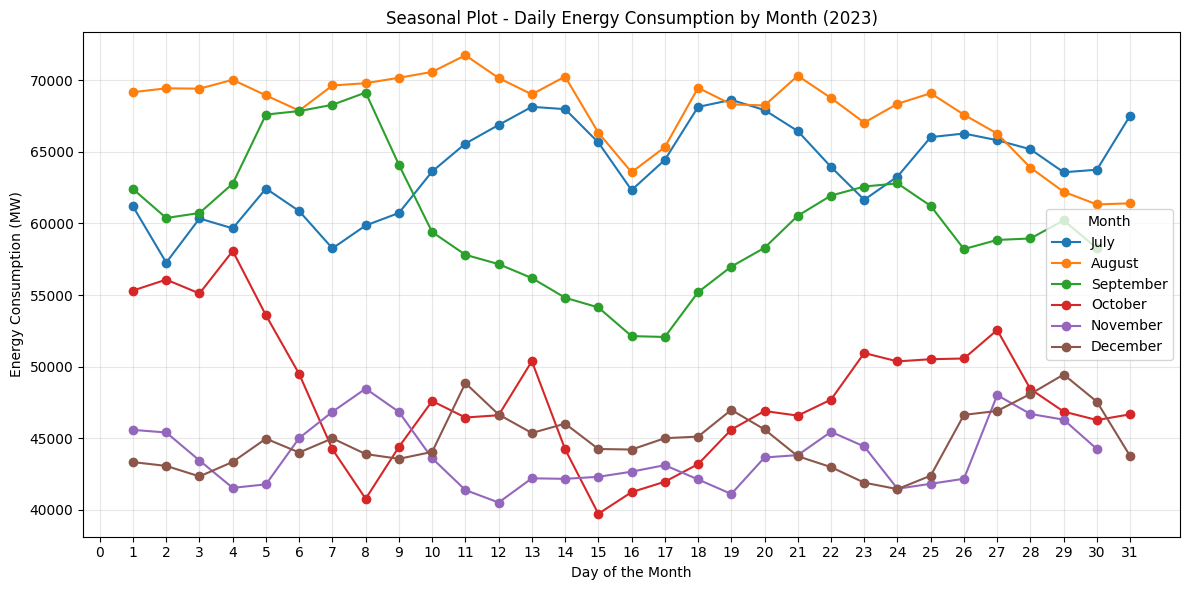

In [ ]:
# Seasonal plot for daily energy consumption by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

daily_avg = data.groupby(['month', 'day'])['Energy'].mean().reset_index()

plt.figure(figsize=(12, 6))
for month in month_order:
    if month in daily_avg['month'].unique():
        month_data = daily_avg[daily_avg['month'] == month]
        plt.plot(month_data['day'], month_data['Energy'], marker='o', label=month)

plt.title('Seasonal Plot - Daily Energy Consumption by Month (2023)')
plt.xlabel('Day of the Month')
plt.ylabel('Energy Consumption (MW)')
plt.xticks(range(0, 32))
plt.legend(title='Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

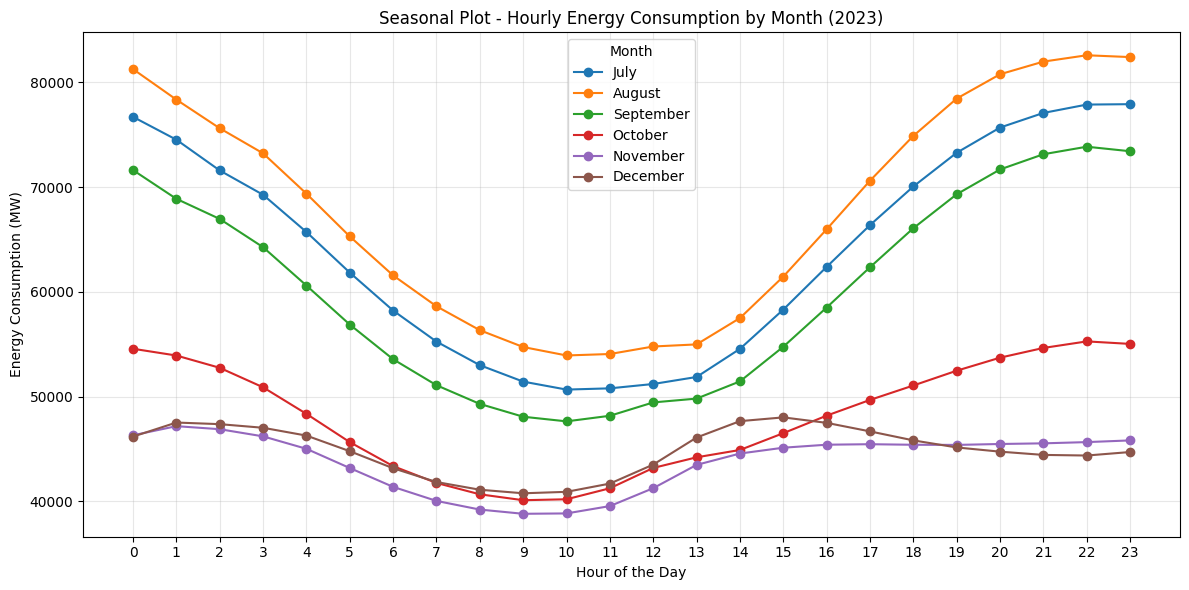

In [ ]:
#seasonal plot for hourly energy consumption by month
hourly_avg = data.groupby(['month', 'hour'])['Energy'].mean().reset_index()

plt.figure(figsize=(12, 6))
for month in month_order:
    if month in hourly_avg['month'].unique():
        month_data = hourly_avg[hourly_avg['month'] == month]
        plt.plot(month_data['hour'], month_data['Energy'], marker='o', label=month)

plt.title('Seasonal Plot - Hourly Energy Consumption by Month (2023)')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (MW)')
plt.xticks(range(0, 24))
plt.legend(title='Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

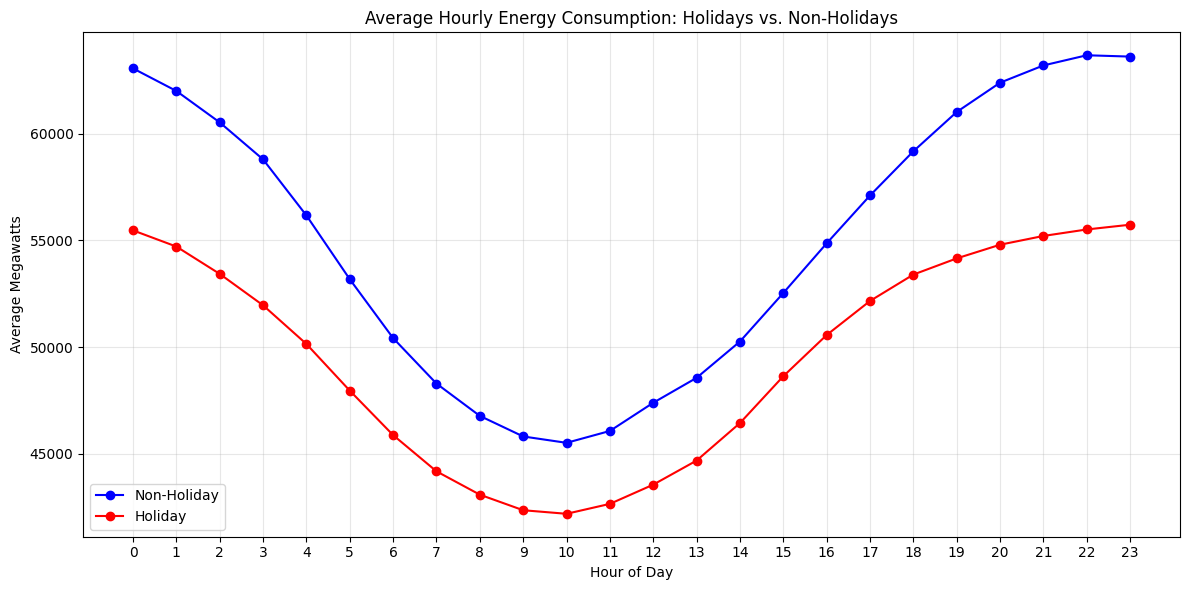

Mean Energy Consumption (MW):
Non-Holidays: 55021.81
Holidays: 49542.75


In [148]:
# Calculate average daily profile by holiday status
daily_profile = data.groupby(['hour', 'IsHoliday'])['Energy'].mean().unstack()

plt.figure(figsize=(12, 6))
plt.plot(daily_profile.index, daily_profile[0], label='Non-Holiday', color='blue', marker='o', linestyle='-')
plt.plot(daily_profile.index, daily_profile[1], label='Holiday', color='red', marker='o', linestyle='-')
plt.title('Average Hourly Energy Consumption: Holidays vs. Non-Holidays')
plt.xlabel('Hour of Day')
plt.ylabel('Average Megawatts')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print('Mean Energy Consumption (MW):')
print(f'Non-Holidays: {daily_profile[0].mean():.2f}')
print(f'Holidays: {daily_profile[1].mean():.2f}')